# 3: Bike rental prediction

We would like to use machine learning to make various predictions about our bike rental data. 

Firstly, we would like to be able to predict the number of daily rentals - this will be framed as a regression problem and carried out on both the Dublin and London data. 

Secondly, in order to plan and manage a bike rental network, the controllers need to remove bikes from full stations so that more can be dropped off, and need to add bikes to empty stations so that more rentals can be made. In order to facilitate this, it would be useful to be able to predict when a station is in need of an intervention (at 0% or 100% capacity). This can be framed as a classification problem.


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from pathlib import Path
import datetime
import warnings
import holidays
import random
import time
import pickle

warnings.filterwarnings('ignore')

chart_folder = Path('charts/')
data_folder = Path('data/')

model_folder = Path('models/')
if not model_folder.exists():
    model_folder.mkdir()
    
sns.set(style="darkgrid", font='serif', rc={'lines.linewidth': 0.7})    


## 3.1: Daily rental prediction

In [18]:
daily_data = pd.read_parquet(data_folder/'dublin_london_daily_rentals.parquet')
daily_data.head() 

,city,date,num_rentals
0,Dublin,2018-08-01,4431.0
1,Dublin,2018-08-02,8392.0
2,Dublin,2018-08-03,7798.0
3,Dublin,2018-08-04,5040.0
4,Dublin,2018-08-05,4384.0


As we only have the city, the date and the number of rentals to use in this dataset, we would like to extract additional features from the date column.

We will use, the day of the week, the month of the year, whether the day is a weekend or weekday, and whether the day is a public holiday. Additionally, as we know from our statistical analysis that bike rental behaviour changed significantly post-covid, we will use an indicator variable for this.

In [19]:
daily_data['day_of_week_name'] = daily_data['date'].dt.day_name()
daily_data['month_name'] = daily_data['date'].dt.month_name()
daily_data['is_weekend'] = daily_data['date'].dt.day_name().isin(['Saturday', 'Sunday'])
daily_data.head()

,city,date,num_rentals,day_of_week_name,month_name,is_weekend
0,Dublin,2018-08-01,4431.0,Wednesday,August,False
1,Dublin,2018-08-02,8392.0,Thursday,August,False
2,Dublin,2018-08-03,7798.0,Friday,August,False
3,Dublin,2018-08-04,5040.0,Saturday,August,True
4,Dublin,2018-08-05,4384.0,Sunday,August,True


In [105]:
ireland_holidays = holidays.Ireland(years=set(daily_data[daily_data['city'] == 'Dublin']['date'].dt.year))
england_holidays = holidays.UnitedKingdom(years=set(daily_data[daily_data['city'] == 'London']['date'].dt.year))
daily_data['is_holiday'] = daily_data.apply(lambda row: row['date'] in ireland_holidays if row['city'] == 'Dublin' else row['date'] in england_holidays, axis=1)
daily_data.loc[daily_data['is_holiday']].head()

,city,date,num_rentals,day_of_week_name,month_name,is_weekend,is_holiday,pre_covid
5,Dublin,2018-08-06,4277.0,Monday,August,False,True,True
89,Dublin,2018-10-29,3768.0,Monday,October,False,True,True
146,Dublin,2018-12-25,1253.0,Tuesday,December,False,True,True
147,Dublin,2018-12-26,1893.0,Wednesday,December,False,True,True
153,Dublin,2019-01-01,2047.0,Tuesday,January,False,True,True


In [21]:
daily_data['pre_covid'] = daily_data['date'] < datetime.datetime(2020,3,1)

Our data contains several categorical columns - these have no sensible numerical representation so we will one hot encode them so that the model sees several binary variables instead of one categorical variable. It should be noted however, that in the case of monthly seasonal effect, if we had some numerical variable or variables that was highly correlated with the seasonal effect, such as average temperature or rainfall for example, we could potentially use these instead of the monthly dummy variables.

In [30]:
cat_cols = ['city', 'day_of_week_name', 'month_name']
cat_subset = daily_data[cat_cols]

encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(cat_subset)
df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))

one_hot_df = pd.concat([daily_data, df_encoded], axis=1)
one_hot_df.drop(columns=cat_cols+['date'], inplace=True)
one_hot_df.head()

,num_rentals,is_weekend,is_holiday,pre_covid,city_Dublin,city_London,day_of_week_name_Friday,day_of_week_name_Monday,day_of_week_name_Saturday,day_of_week_name_Sunday,...,month_name_December,month_name_February,month_name_January,month_name_July,month_name_June,month_name_March,month_name_May,month_name_November,month_name_October,month_name_September
0,4431.0,False,False,True,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8392.0,False,False,True,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7798.0,False,False,True,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5040.0,True,False,True,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4384.0,True,False,True,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_df.drop(columns=['num_rentals']), one_hot_df['num_rentals'], test_size=0.2, random_state=495)

The three models to compare are random forest, xgboost, and lightGBM. All three are ensemble tree models, which should work well as the large number of binary and categorical features should facilitate building rules.

XGB and lightGBM are both boosting algorithms as opposed to random forests bagging approach. Each tree is grown using information from previously grown trees (James et al. 2013) so that each sequential tree is able to reduce its error using information from mistakes made by previous iterations.

XGB and lightGBM were chosen because - xgboost is quite powerful and very scalable, which could be important given the scale of the dublinbikes hourly data, and LightGBM is typically quick to train and has a low memory footprint, which could be a consideration when including predictions as part of a web-based application or dashboard. 

In [42]:
random.seed(495)

rf_params = {'max_depth': [3, 5, 10, 20, None], 'n_estimators': [50, 100, 200], 'max_features': ['sqrt', None]}
xgb_params = {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 9]}
lgb_params = {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 9], 'verbose': [-1]}

models = {
    'RandomForest': GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid=rf_params).fit(X_train, y_train).best_estimator_,
    'XGB': GridSearchCV(xgb.XGBRegressor(n_jobs=-1), param_grid=xgb_params).fit(X_train, y_train).best_estimator_,
    'LightGBM': GridSearchCV(lgb.LGBMRegressor(n_jobs=-1), param_grid=lgb_params).fit(X_train, y_train).best_estimator_
}

In [51]:
results_df = pd.DataFrame(columns=['model', 'mse', 'r2'])

for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results_dict = {
            'model': name,
            'mse': mse,
            'r2': r2
        }
    results_df = results_df.append(results_dict, ignore_index=True)
    
results_df

{'model': 'RandomForest', 'mse': 36698317.59313881, 'r2': 0.7800339604324046}
{'model': 'XGB', 'mse': 35595054.11510015, 'r2': 0.7866468112054085}
{'model': 'LightGBM', 'mse': 35572656.222947836, 'r2': 0.7867810619273634}


,model,mse,r2
0,RandomForest,3.669832e+07,0.780034
1,XGB,3.559505e+07,0.786647
2,LightGBM,3.557266e+07,0.786781


LightGBM minimises the mean squared error and maximises the r2 score, so is deemed to be the best performing model (although its preformance is only marginally better than xgboost). This can be seen visually by comparing the models' scores in a barplot. Here, each bar is narrowed and the fill colour is removed in order to display the same information with reduced data ink, in accordance with Tufte's principals.

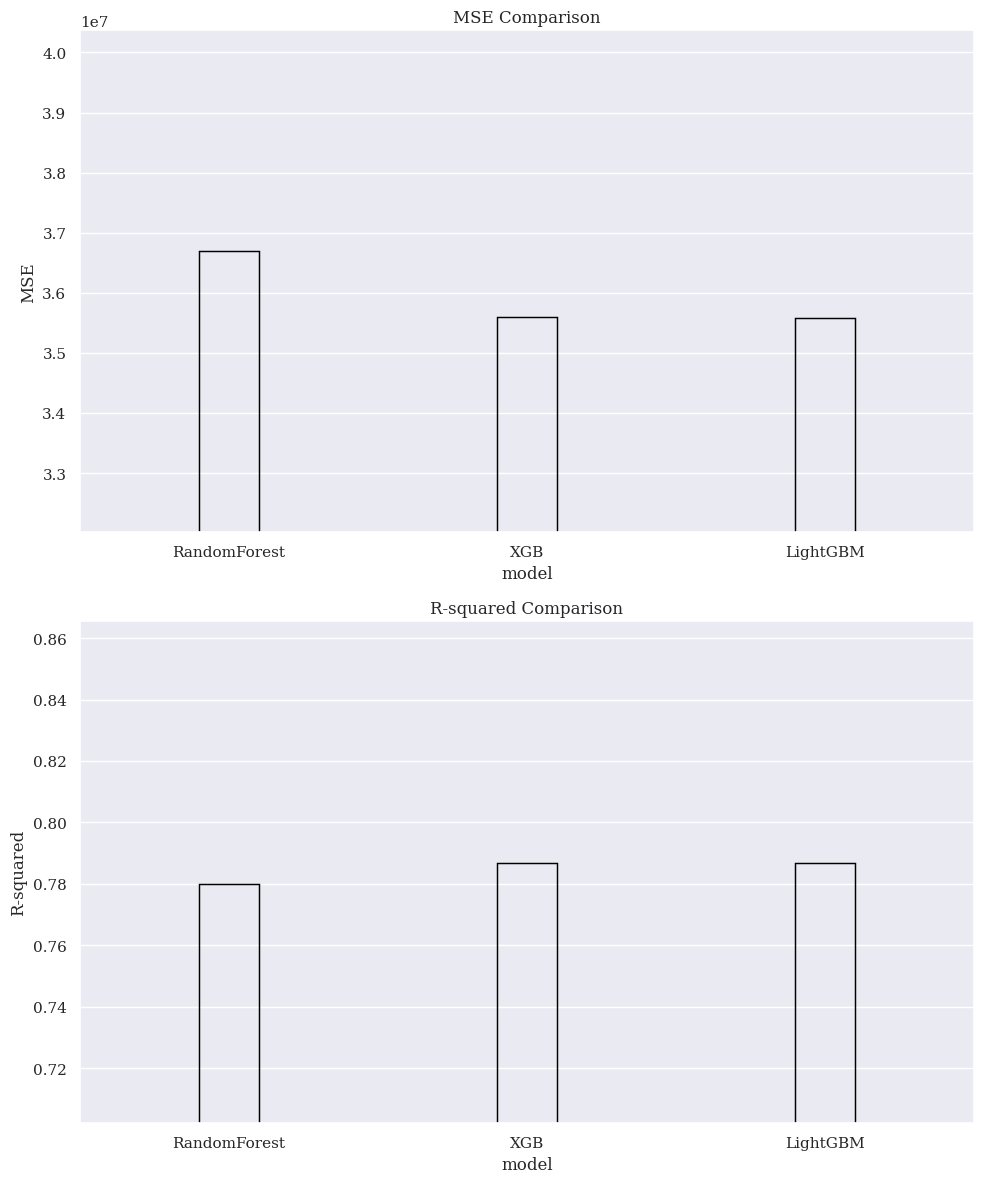

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.barplot(ax=axes[0], data=results_df, x='model', y='mse', width=0.2, edgecolor='black', fill=None)
axes[0].set_title('MSE Comparison')
axes[0].set_ylabel('MSE')
axes[0].set_ylim(np.min(results_df['mse']) - np.min(results_df['mse'])*0.1, np.max(results_df['mse']) + np.max(results_df['mse'])*0.1) 

sns.barplot(ax=axes[1], data=results_df, x='model', y='r2', width=0.2, edgecolor='black', fill=None)
axes[1].set_title('R-squared Comparison')
axes[1].set_ylabel('R-squared')
axes[1].set_ylim(np.min(results_df['r2']) - np.min(results_df['r2'])*0.1, np.max(results_df['r2']) + np.max(results_df['r2'])*0.1) 

plt.tight_layout()
plt.savefig(chart_folder / 'daily_prediction_comparison.png')
plt.show();

Looking at the feature importances - we see that the city=Dublin boolean is the most important feature, which is to be expected, followed by the pre_covid boolean. This makes sense as we noted a shift in behaviour post-covid in section 2.1.2. 

Whether the day is a weekend is the next most important feature, which again makes sense as we would imagine one of the primary uses of the bike network in both cities is to commute to work. We also see is_holiday ranking highly, which could have a similar influence.

We can also note that the December dummy variable is the most important of the seasonal dummies. This is possibly due to cycling being a less attractive transport option in Winter.

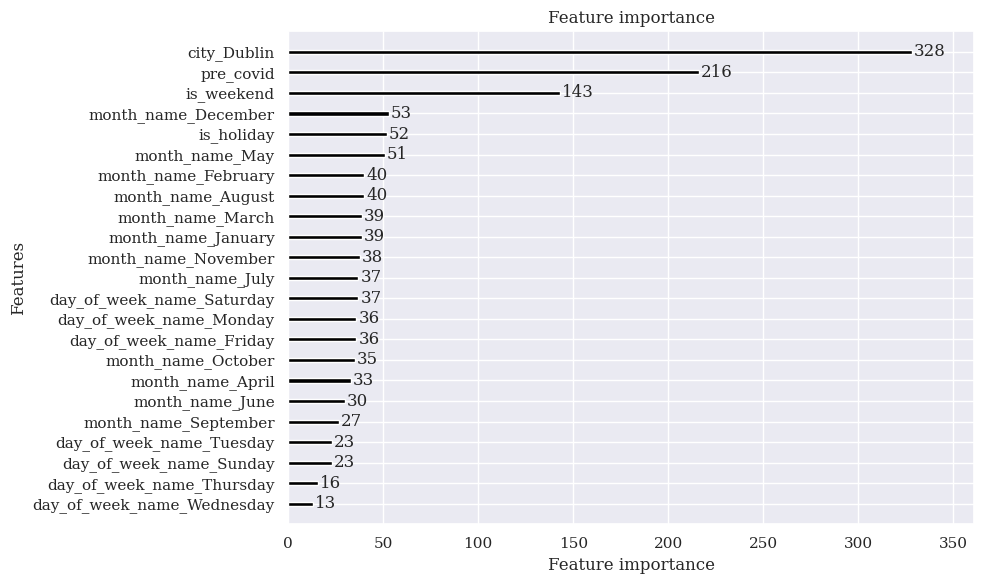

In [96]:
x = lgb.plot_importance(models['LightGBM'], figsize=(10,6), color='black')
plt.tight_layout()
x.figure.savefig(chart_folder / 'lightgbm_importance.png');

In [84]:
# test set original dataframe
original_test = daily_data.iloc[y_test.index]
original_test['prediction'] = y_pred = models['LightGBM'].predict(X_test)
original_test.head()

,city,date,num_rentals,day_of_week_name,month_name,is_weekend,is_holiday,pre_covid,prediction
3594,London,2015-02-23,21857.0,Monday,February,False,False,True,20943.083917
511,Dublin,2020-02-05,7315.0,Wednesday,February,False,False,True,7578.045843
3750,London,2015-07-29,37021.0,Wednesday,July,False,False,True,37172.519229
5733,London,2021-01-01,10986.0,Friday,January,False,True,False,19632.645708
513,Dublin,2020-02-07,6794.0,Friday,February,False,False,True,6746.008564


Visualising the errors, we can see that the median error is around 0, indicating that our model is unbiased. We also see that the IQR is narrow for both cities, indicating a relatively good performance as the majority of the errors fall close to 0. 

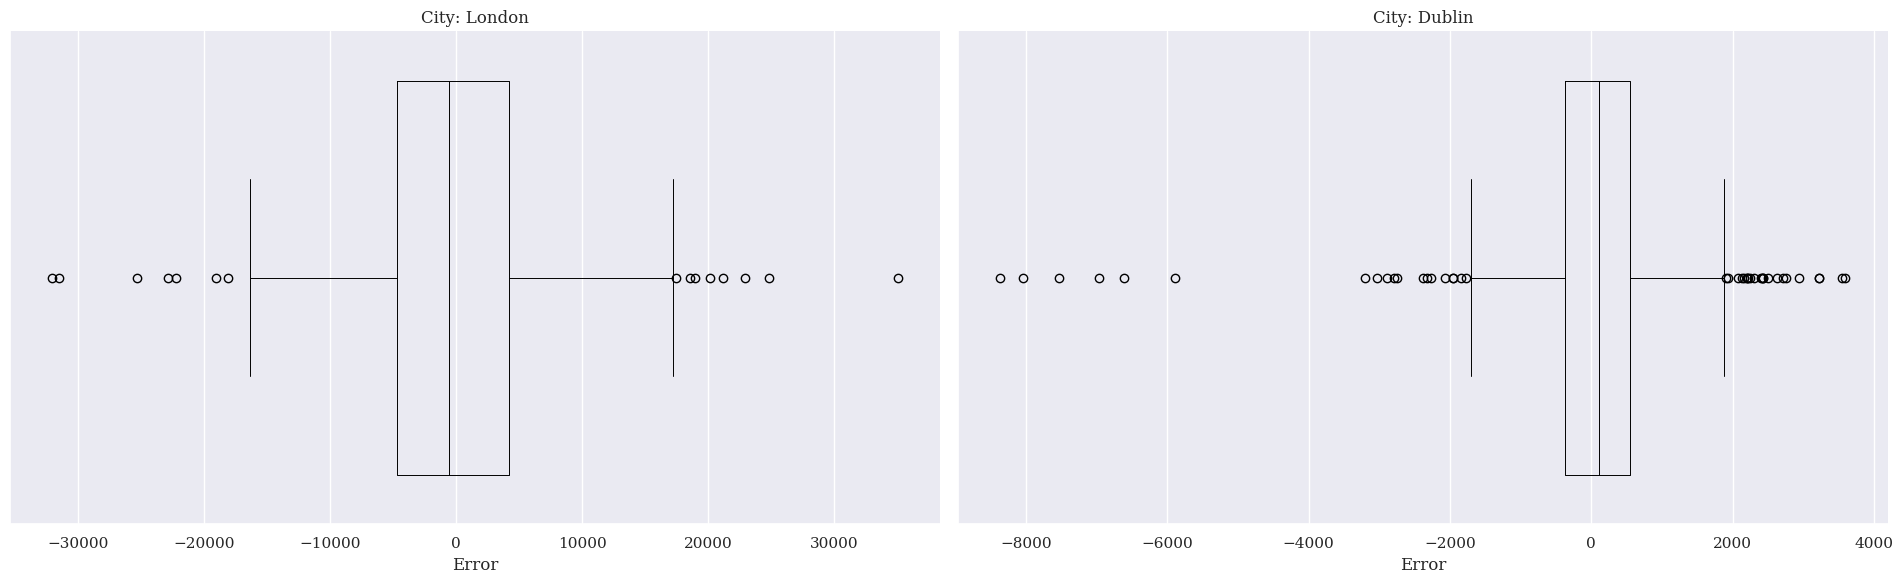

In [95]:
g = sns.FacetGrid(original_test, 
                  col="city", 
                  height=6, 
                  aspect=1.6, 
                  sharex=False)

g.map(sns.boxplot, 'error', fill=None, color='black')
g.set_axis_labels("Error", "")
g.set_titles("City: {col_name}");

g.savefig(chart_folder / 'error_boxplots.png')

## 3.2: Station Issue classification

To begin with, we only consider 2023 data, as this cuts down on the number of rows to process considerably and allows for quicker iteration. We also remove the oriel street test station with id 507.

In [2]:
small_hourly_df = pd.read_parquet(data_folder/'dublinbikes/combined_data_weather_population.parquet', filters=[
    ('time', '>=', datetime.datetime(2023,1,1)),
    ('station_id', '!=', 507)
])

In [3]:
print(small_hourly_df.shape)
small_hourly_df.head()

(1921575, 25)


,station_id,time,last_updated,name,bike_stands,available_bike_stands,available_bikes,status,address,latitude,...,day_of_week,day_of_week_name,month,month_name,day_of_month,hour_of_day,rain,temp,rhum,population
0,1,2023-01-01 00:00:03,2022-12-31 23:59:39,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,...,6,Sunday,1,January,1,0,0.3,6.8,91.0,5522.0
1,1,2023-01-01 00:30:02,2023-01-01 00:21:23,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,...,6,Sunday,1,January,1,0,0.3,6.8,91.0,5522.0
2,1,2023-01-01 01:00:03,2023-01-01 00:50:23,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,...,6,Sunday,1,January,1,1,0.0,6.2,86.0,5522.0
3,1,2023-01-01 01:30:03,2023-01-01 01:20:40,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,...,6,Sunday,1,January,1,1,0.0,6.2,86.0,5522.0
4,1,2023-01-01 02:00:03,2023-01-01 01:50:55,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,...,6,Sunday,1,January,1,2,0.0,4.5,91.0,5522.0


In [4]:
small_hourly_df.columns

Index(['station_id', 'time', 'last_updated', 'name', 'bike_stands',
       'available_bike_stands', 'available_bikes', 'status', 'address',
       'latitude', 'longitude', 'available_bike_change', 'num_returns',
       'num_rentals', 'year', 'day_of_week', 'day_of_week_name', 'month',
       'month_name', 'day_of_month', 'hour_of_day', 'rain', 'temp', 'rhum',
       'population'],
      dtype='object')

In [5]:
small_hourly_df['half_hour'] = small_hourly_df['time'].dt.minute//30*30 == 30
small_hourly_df['empty_station'] = small_hourly_df['available_bikes'] == 0
small_hourly_df['full_station'] = small_hourly_df['available_bike_stands'] == 0
small_hourly_df['needs_attention'] = small_hourly_df['full_station'] | small_hourly_df['empty_station']
small_hourly_df.head()

,station_id,time,last_updated,name,bike_stands,available_bike_stands,available_bikes,status,address,latitude,...,day_of_month,hour_of_day,rain,temp,rhum,population,half_hour,empty_station,full_station,needs_attention
0,1,2023-01-01 00:00:03,2022-12-31 23:59:39,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,...,1,0,0.3,6.8,91.0,5522.0,False,True,False,True
1,1,2023-01-01 00:30:02,2023-01-01 00:21:23,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,...,1,0,0.3,6.8,91.0,5522.0,True,True,False,True
2,1,2023-01-01 01:00:03,2023-01-01 00:50:23,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,...,1,1,0.0,6.2,86.0,5522.0,False,True,False,True
3,1,2023-01-01 01:30:03,2023-01-01 01:20:40,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,...,1,1,0.0,6.2,86.0,5522.0,True,True,False,True
4,1,2023-01-01 02:00:03,2023-01-01 01:50:55,CLARENDON ROW,31,31,0,OPEN,Clarendon Row,53.3409,...,1,2,0.0,4.5,91.0,5522.0,False,True,False,True


In [6]:
small_hourly_df.isna().sum()

station_id                   0
time                         0
last_updated                 0
name                         0
bike_stands                  0
available_bike_stands        0
available_bikes              0
status                       0
address                      0
latitude                     0
longitude                    0
available_bike_change        0
num_returns                  0
num_rentals                  0
year                         0
day_of_week                  0
day_of_week_name             0
month                        0
month_name                   0
day_of_month                 0
hour_of_day                  0
rain                     98382
temp                     98382
rhum                     98382
population                   0
half_hour                    0
empty_station                0
full_station                 0
needs_attention              0
dtype: int64

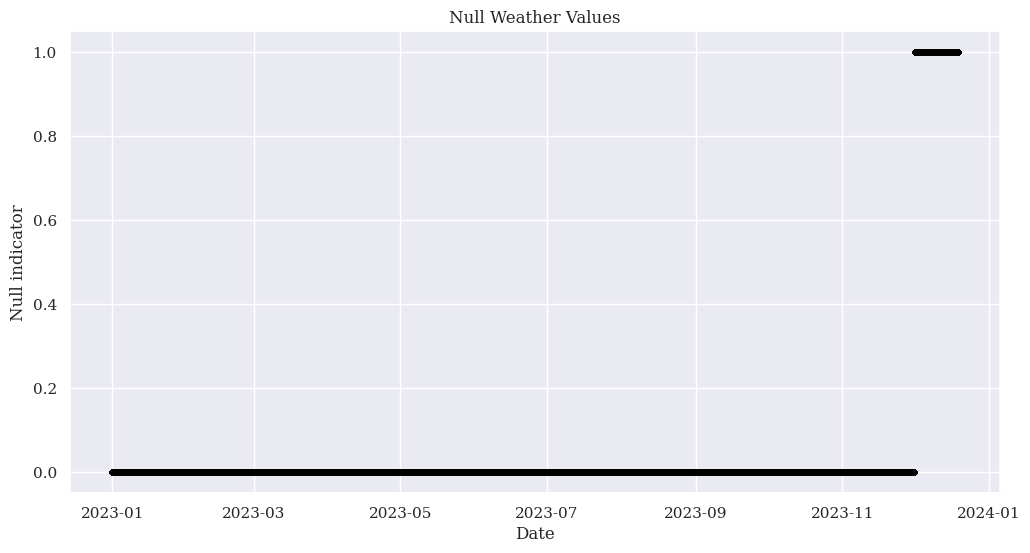

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(small_hourly_df['time'], small_hourly_df['rain'].isnull(), marker='.', linestyle='', color='black')
plt.title('Null Weather Values')
plt.xlabel('Date')
plt.ylabel('Null indicator')
plt.show()

All of the null values are towards the end of the time series - indicating that the met eireann data we retrieved simply did not have those values yet, we can safely exclude the tail of the dataset without having to do additional imputation (if there were null value throughout the dataset then back filling with the last seen weather data might be appropriate for example).

At this point, for performance, we remove the half-hourly entries. Although this is potentially useful data, the volume it adds is difficult to handle in-memory on my machine.

In [8]:
print(small_hourly_df.shape)
small_hourly_df = small_hourly_df.loc[(~pd.isna(small_hourly_df['rain'])) & (~small_hourly_df['half_hour'])] 
print(small_hourly_df.shape)

(1921575, 29)
(911710, 29)


In [9]:
# sample data is all post-covid so don't need a variable for that

small_hourly_df['is_weekend'] = small_hourly_df['time'].dt.day_name().isin(['Saturday', 'Sunday'])

ireland_holidays = holidays.Ireland(years=set(small_hourly_df['year']))
small_hourly_df['is_holiday'] = small_hourly_df.apply(lambda row: row['time'] in ireland_holidays, axis=1)

cat_cols = ['name', 'day_of_week_name', 'month_name', 'hour_of_day']
cat_subset = small_hourly_df[cat_cols]

For the same reasons as above, we will fit a one hot encoder to the categorical columns in the data.

We could also elect to use a scaler at this point, as several variables are on vastly different scales (rainfall mm vs population for example. The use of a scaler such as StandardScaler enusres that the range of the variables is comparison, which is important as many ML algorithms rely on detecting patterns in the variance of features, and if one featuree is spread across a wide range and another isn't, the algorithm might treat the large differences in the widely spread variable as more important than the comparatively small differences in the other variable. This could lead to importance being attributed to a variable due to how it is encoded rather than the signal it contains. Also, none of the variables are on a sufficiently small scale that numerical precision is a consideration, which is something that a scaler could also mitigate.

However, the tree based models we are focusing on typically do well with data on several scales due to their rules-based nature. Scaling would be a more important consideration if we were looking closely at models such as SVM.

In [10]:
cont_cols = ['rain', 'temp', 'rhum', 'population', 'bike_stands']
bin_cols = ['is_holiday', 'is_weekend']

encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(cat_subset)
df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))

In [11]:
df_encoded.shape

(911710, 157)

In [12]:
df_encoded.head()

,name_AVONDALE ROAD,name_BENSON STREET,name_BLACKHALL PLACE,name_BLESSINGTON STREET,name_BOLTON STREET,name_BROADSTONE,name_BROOKFIELD ROAD,name_BUCKINGHAM STREET LOWER,name_CATHAL BRUGHA STREET,name_CHARLEMONT PLACE,...,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
small_hourly_df[cont_cols + bin_cols + ['needs_attention']].shape

(911710, 8)

In [14]:
small_hourly_df[cont_cols + bin_cols + ['needs_attention']].head()

,rain,temp,rhum,population,bike_stands,is_holiday,is_weekend,needs_attention
0,0.3,6.8,91.0,5522.0,31,True,True,True
2,0.0,6.2,86.0,5522.0,31,True,True,True
4,0.0,4.5,91.0,5522.0,31,True,True,True
6,0.1,4.0,93.0,5522.0,31,True,True,True
8,0.0,2.5,96.0,5522.0,31,True,True,True


In [15]:
one_hot_df = pd.concat([small_hourly_df[cont_cols + bin_cols + ['needs_attention']].reset_index(drop=True), df_encoded], axis=1)
one_hot_df.shape

(911710, 165)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_df.drop(columns=['needs_attention']), one_hot_df['needs_attention'], test_size=0.2, random_state=495)

Several models and search parameters were iteratively explored in accordance with a CRISP-DM workflow (Wirth & Hipp, 2000). Many configurations were found to be prohibitively expensive to train due to the dimension of the data- a support vector classifier for example, was left to run overnight before it was abandoned. LightGBM was focused on over XGB as the boosting algorithm of choice given its better performance in the previous section.

In [17]:
random.seed(495)

# xgb and lgb are similar models, xgb is omitted to save processing time as lgb performed better in the previous analysis
# svm was tried - ran for 10 hours without completing
logistic_params = {'C': [0.1, 1, 10]}
rf_params = {'max_depth': [3, 5, 10], 'n_estimators': [10, 20, 50], 'max_features': ['sqrt', None]}
lgb_params = {'learning_rate': [0.1, 0.2], 'n_estimators': [10, 20, 50], 'max_depth': [3, 6], 'verbose': [-1]}

# this is a long running step, doing it explicity in a loop rather than a dict definition lets us track progress
model_names = ['LogisticRegression','RandomForest', 'LightGBM']
param_sets = [logistic_params, rf_params, lgb_params]
classifiers = [
    LogisticRegression(), 
    RandomForestClassifier(n_jobs=8),
    lgb.LGBMClassifier(n_jobs=8)
]

models = {}
for name, params, model in zip(model_names, param_sets, classifiers):
    print(f"\nTraining model: {name}")
    t0 = time.time()
    trained = GridSearchCV(model, param_grid=params).fit(X_train, y_train).best_estimator_
    print(f"Trained model in {time.time() - t0} seconds")
    models[name] = trained


Training model: LogisticRegression
Trained model in 317.96672344207764 seconds

Training model: RandomForest
Trained model in 2531.386077642441 seconds

Training model: LightGBM
Trained model in 96.89859318733215 seconds


In [20]:
# Save model artifacts to disk to avoid recomputation if the kernel dies
for name, model in models.items():
    with open(model_folder/f"{name}.pickle", 'wb') as f:
        pickle.dump(model, f)

In [63]:
results = []
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    y_score = model.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, y_score)
    
    c_rep = classification_report(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    results.append(
        {
            "model": model_name,
            "accuracy": accuracy,
            "roc": roc
        }
    )
    
    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(c_rep)
    print("Confusion Matrix:")
    print(conf)
    
results_df = pd.DataFrame(results)


LogisticRegression:
Accuracy: 0.8683
Classification Report:
              precision    recall  f1-score   support

       False       0.87      1.00      0.93    158326
        True       0.00      0.00      0.00     24016

    accuracy                           0.87    182342
   macro avg       0.43      0.50      0.46    182342
weighted avg       0.75      0.87      0.81    182342

Confusion Matrix:
[[158326      0]
 [ 24016      0]]

RandomForest:
Accuracy: 0.8705
Classification Report:
              precision    recall  f1-score   support

       False       0.87      1.00      0.93    158326
        True       0.67      0.03      0.06     24016

    accuracy                           0.87    182342
   macro avg       0.77      0.52      0.50    182342
weighted avg       0.84      0.87      0.82    182342

Confusion Matrix:
[[157921    405]
 [ 23212    804]]

LightGBM:
Accuracy: 0.8705
Classification Report:
              precision    recall  f1-score   support

       False      

We can compare the accuracies of the models as well as see the various metrics taken from the classification reports and confustion matrices. We see that there are many, many false negatives in every model. And indeed, logistic regression has no true positives at all. The model appears to have taken a shortcut in classifying everything as a negative as there are so many of these in comparison to positive cases. We can try and rectify this by resampling to fix the class imbalance using random under sampling (this also mitigates performance issues that we might run into if using an oversampler such as smote given our data dimension is large). 

In testing, smote was used as an oversampler but the performance hit was very large.

In [50]:
from imblearn.under_sampling import RandomUnderSampler

In [51]:
rus = RandomUnderSampler(random_state=495)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [53]:
X_train.shape

(729368, 164)

In [52]:
X_train_resampled.shape

(192366, 164)

In [54]:
rus_models = {}
for name, params, model in zip(model_names, param_sets, classifiers):
    print(f"\nTraining model: {name}")
    t0 = time.time()
    trained = GridSearchCV(model, param_grid=params).fit(X_train_resampled, y_train_resampled).best_estimator_
    print(f"Trained model in {time.time() - t0} seconds")
    rus_models[name] = trained

for name, model in rus_models.items():
    with open(model_folder/f"rus_{name}.pickle", 'wb') as f:
        pickle.dump(model, f)


Training model: LogisticRegression
Trained model in 71.26271939277649 seconds

Training model: RandomForest
Trained model in 377.13987016677856 seconds

Training model: LightGBM
Trained model in 30.003865480422974 seconds


In [60]:
rus_results = []
for model_name, model in rus_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    y_score = model.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, y_score)
    
    c_rep = classification_report(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    rus_results.append(
        {
            "model": model_name,
            "accuracy": accuracy,
            "roc": roc
        }
    )
    
    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(c_rep)
    print("Confusion Matrix:")
    print(conf)
    
rus_results_df = pd.DataFrame(rus_results)


LogisticRegression:
Accuracy: 0.5600
Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.56      0.69    158326
        True       0.17      0.58      0.26     24016

    accuracy                           0.56    182342
   macro avg       0.53      0.57      0.47    182342
weighted avg       0.80      0.56      0.63    182342

Confusion Matrix:
[[88084 70242]
 [ 9995 14021]]

RandomForest:
Accuracy: 0.7383
Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.78      0.84    158326
        True       0.25      0.48      0.33     24016

    accuracy                           0.74    182342
   macro avg       0.58      0.63      0.58    182342
weighted avg       0.82      0.74      0.77    182342

Confusion Matrix:
[[123100  35226]
 [ 12487  11529]]

LightGBM:
Accuracy: 0.6838
Classification Report:
              precision    recall  f1-score   support

       False       0.9

In [64]:
results_df

,model,accuracy,roc
0,LogisticRegression,0.868291,0.556796
1,RandomForest,0.870480,0.662666
2,LightGBM,0.870469,0.734978


In [62]:
rus_results_df

,model,accuracy,roc
0,LogisticRegression,0.559964,0.596203
1,RandomForest,0.738332,0.676920
2,LightGBM,0.683814,0.738499


We can see that the accuracy of each of our models has decreased by quite a bit. However, the models are no longer taking the shortcut of alwyas predicting the False class, and indeed, the AUC has improved for each model.
RandomForest has the highest accuracy, whereas LightGBM has the highest AUC - either of these could be appropriate choices of model depending on the context, but we will choose LightGBM as it is better at distinguishing between our two classes, which we value more than pure accuracy.

In [65]:
comparison_df = pd.merge(results_df, rus_results_df, on='model', suffixes=('_no_undersampling', '_undersampling'))
comparison_df

,model,accuracy_no_undersampling,roc_no_undersampling,accuracy_undersampling,roc_undersampling
0,LogisticRegression,0.868291,0.556796,0.559964,0.596203
1,RandomForest,0.870480,0.662666,0.738332,0.676920
2,LightGBM,0.870469,0.734978,0.683814,0.738499


In [68]:
comparison_df

,model,accuracy_no_undersampling,roc_no_undersampling,accuracy_undersampling,roc_undersampling
0,LogisticRegression,0.868291,0.556796,0.559964,0.596203
1,RandomForest,0.870480,0.662666,0.738332,0.676920
2,LightGBM,0.870469,0.734978,0.683814,0.738499


In comparing these classification metrics, we once again adjust our visualisations for colourblindness, reduce bar width to lower data ink usage, have multiple plots side by side so that they can easily be compared, and use a common legend to avoid duplication of chart data - all aspects of visualisations that are encouraged by Tufte.

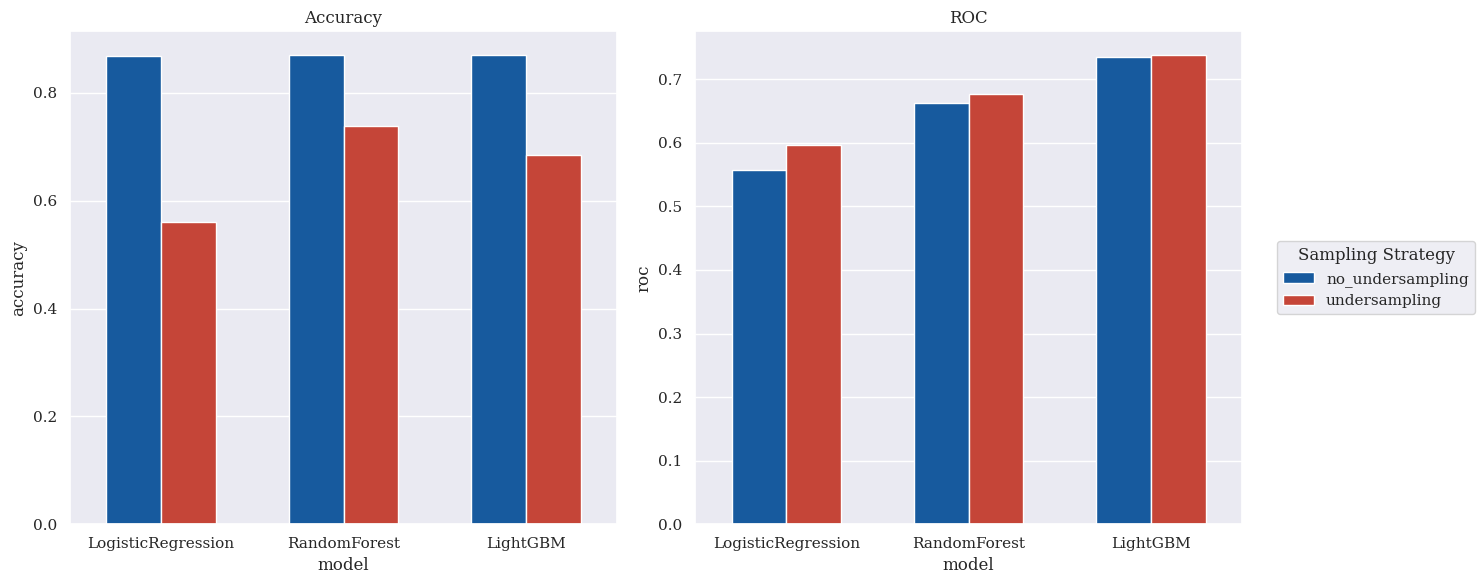

In [86]:
melted_df_accuracy = pd.melt(comparison_df, id_vars='model', value_vars=['accuracy_no_undersampling', 'accuracy_undersampling'],
                              var_name='undersampling', value_name='accuracy')

melted_df_roc = pd.melt(comparison_df, id_vars='model', value_vars=['roc_no_undersampling', 'roc_undersampling'],
                         var_name='undersampling', value_name='roc')

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='model', y='accuracy', hue='undersampling', data=melted_df_accuracy, palette=['#005AB5', '#DC3220'], width=0.6)
plt.title('Accuracy')
plt.legend().set_visible(False)

plt.subplot(1, 2, 2)
melted_df_roc['undersampling'] = melted_df_roc['undersampling'].apply(lambda x: x[4:])
g = sns.barplot(x='model', y='roc', hue='undersampling', data=melted_df_roc, palette=['#005AB5', '#DC3220'], width=0.6)
plt.legend(title='Sampling Strategy', bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.title('ROC')

plt.tight_layout()
plt.savefig(chart_folder / 'classification_metrics.png')
plt.show()

After one hot encoding, we end up with a very wide dataset - 165 columns. We could try to apply dimensional reduction techniques to make this more manageable, however PCA does not seem appropriate since most of the varaibles here are the result of our one hot encoding. 

TSNE or UMAP might be more useful, however  given the data is quite large, I could not get it to run in any reasonable amount of time on my machine. 

In [16]:
# X = one_hot_df[[x for x in one_hot_df.columns if x != 'needs_attention']]
# y = one_hot_df['needs_attention']

In [17]:
# from sklearn.manifold import TSNE
# import umap 
# import time

# tsne = TSNE(n_components=2, random_state=495, n_jobs=-1)

# t0 = time.time()
# X_tsne = tsne.fit_transform(X)
# print(f"Fitted t-SNE in {time.time() - t0:.2f} seconds")

2024-01-02 17:59:51.290941: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 17:59:51.417834: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 17:59:51.417862: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 17:59:51.418595: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 17:59:51.482485: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 17:59:51.483424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [1]:
# umap_model = umap.UMAP(n_components=2, n_jobs=-1)

# t0 = time.time()
# X_umap = umap_model.fit_transform(X)
# print(f"Fitted UMAP in {time.time() - t0:.2f} seconds")

In [ ]:
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, legend='full')
# plt.title('t-SNE')

# plt.subplot(1, 2, 2)
# sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, legend='full')
# plt.title('UMAP')

# plt.tight_layout()
# plt.show()